In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3

## Useful constants

In [2]:
DATA_DIR_10X = Path("../raw/10x_v2/droplet/")
DATA_DIR_SS2 = Path("../raw/ss2_v2/FACS/")

CONSTANTS_SS2 = {
    "min_genes": 500, # taken from the Tabula Muris 2018 paper
    "min_reads": 5e4,
    "norm_count": 1e6
}

pancreas_fname = DATA_DIR_SS2 / "Pancreas-counts.csv"

## Smartseq2 preprocessing steps

### General adata reporting

In [3]:
adata = sc.read_csv(pancreas_fname, first_column_names=True).T

In [4]:
print(adata)

AnnData object with n_obs × n_vars = 1961 × 23433


In [5]:
for cell_name in adata.obs_names:
    print(cell_name)

B21.MAA000574.3_8_M.1.1
D12.MAA000574.3_8_M.1.1
B22.MAA000574.3_8_M.1.1
D13.MAA000574.3_8_M.1.1
C1.MAA000574.3_8_M.1.1
D14.MAA000574.3_8_M.1.1
C2.MAA000574.3_8_M.1.1
C4.MAA000574.3_8_M.1.1
A1.MAA000574.3_8_M.1.1
C5.MAA000574.3_8_M.1.1
A3.MAA000574.3_8_M.1.1
C7.MAA000574.3_8_M.1.1
A4.MAA000574.3_8_M.1.1
C8.MAA000574.3_8_M.1.1
A5.MAA000574.3_8_M.1.1
C10.MAA000574.3_8_M.1.1
A6.MAA000574.3_8_M.1.1
C11.MAA000574.3_8_M.1.1
C12.MAA000574.3_8_M.1.1
A7.MAA000574.3_8_M.1.1
A8.MAA000574.3_8_M.1.1
C15.MAA000574.3_8_M.1.1
C16.MAA000574.3_8_M.1.1
B2.MAA000574.3_8_M.1.1
B5.MAA000574.3_8_M.1.1
C17.MAA000574.3_8_M.1.1
B6.MAA000574.3_8_M.1.1
C18.MAA000574.3_8_M.1.1
B7.MAA000574.3_8_M.1.1
C19.MAA000574.3_8_M.1.1
C20.MAA000574.3_8_M.1.1
B9.MAA000574.3_8_M.1.1
B12.MAA000574.3_8_M.1.1
C21.MAA000574.3_8_M.1.1
B15.MAA000574.3_8_M.1.1
C22.MAA000574.3_8_M.1.1
B16.MAA000574.3_8_M.1.1
D1.MAA000574.3_8_M.1.1
B17.MAA000574.3_8_M.1.1
D3.MAA000574.3_8_M.1.1
B18.MAA000574.3_8_M.1.1
D4.MAA000574.3_8_M.1.1
B19.MAA000574

In [6]:
for gene_name in adata.var_names:
    print(gene_name)

0610005C13Rik
0610007C21Rik
0610007L01Rik
0610007N19Rik
0610007P08Rik
0610007P14Rik
0610007P22Rik
0610008F07Rik
0610009B14Rik
0610009B22Rik
0610009D07Rik
0610009L18Rik
0610009O20Rik
0610010B08Rik
0610010F05Rik
0610010K14Rik
0610010O12Rik
0610011F06Rik
0610011L14Rik
0610012G03Rik
0610012H03Rik
0610030E20Rik
0610031J06Rik
0610031O16Rik
0610037L13Rik
0610037P05Rik
0610038B21Rik
0610038L08Rik
0610039K10Rik
0610040B10Rik
0610040F04Rik
0610040J01Rik
0610043K17Rik
0910001L09Rik
100043387
1100001G20Rik
1110001A16Rik
1110001J03Rik
1110002B05Rik
1110002L01Rik
1110002N22Rik
1110003E01Rik
1110004E09Rik
1110004F10Rik
1110005A03Rik
1110006O24Rik
1110007C09Rik
1110008F13Rik
1110008J03Rik
1110008L16Rik
1110008P14Rik
1110012J17Rik
1110012L19Rik
1110014N23Rik
1110015O18Rik
1110017D15Rik
1110017F19Rik
1110018G07Rik
1110018J18Rik
1110019D14Rik
1110020A21Rik
1110020G09Rik
1110021J02Rik
1110021L09Rik
1110028C15Rik
1110028F11Rik
1110028F18Rik
1110031I02Rik
1110032A03Rik
1110032A04Rik
1110032F04Rik
1110034A24

normalizing counts per cell
    finished (0:00:00)


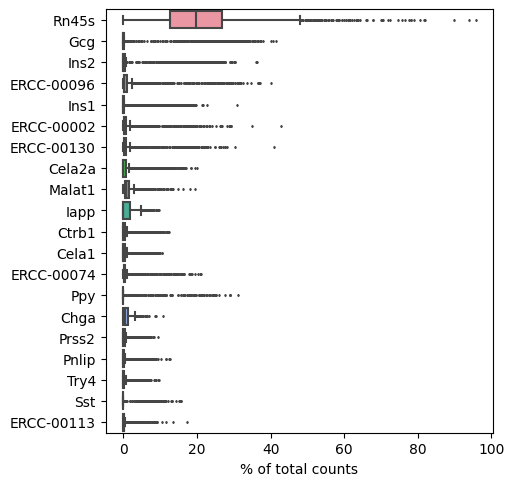

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

### Quality control

In [8]:
# 1. Use UMI counts, not reads
# 2. QC metrics
#    - # reads
#    - # genes
#    - % mitochondrial genes
#    - % ERCC
# 3. [optional] Correct for transcript length bias in SS2
#    Normalize (reads per million)
# 4. Log transform
# 5. Feature selection
# 6. Dimensionality reduction

In [9]:
# computes adata.obs["n_genes"], filters out
sc.pp.filter_cells(adata, min_genes=CONSTANTS_SS2["min_genes"])
sc.pp.filter_cells(adata, min_counts=CONSTANTS_SS2["min_reads"])

filtered out 348 cells that have less than 500 genes expressed
filtered out 33 cells that have less than 50000.0 counts


In [10]:
print(adata)

AnnData object with n_obs × n_vars = 1580 × 23433
    obs: 'n_genes', 'n_counts'


In [11]:
# there are no mitochondrial genes in this dataset
# adata.var["mt"] = adata.var_names.str.lower().str.startswith("mt-")
adata.var["ercc"] = adata.var_names.str.lower().str.startswith("ercc-")

sc.pp.calculate_qc_metrics(adata, qc_vars=["ercc"], percent_top=None, log1p=False, inplace=True)

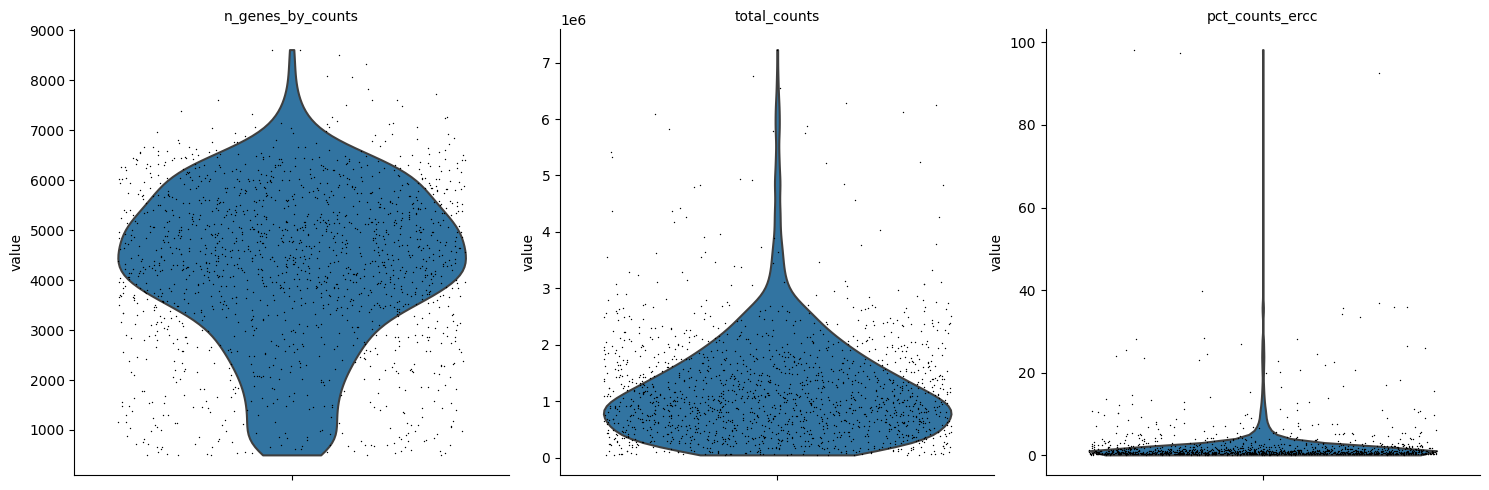

In [12]:
sc.pl.violin(adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_ercc"],
    jitter=0.4,
    multi_panel=True
    )

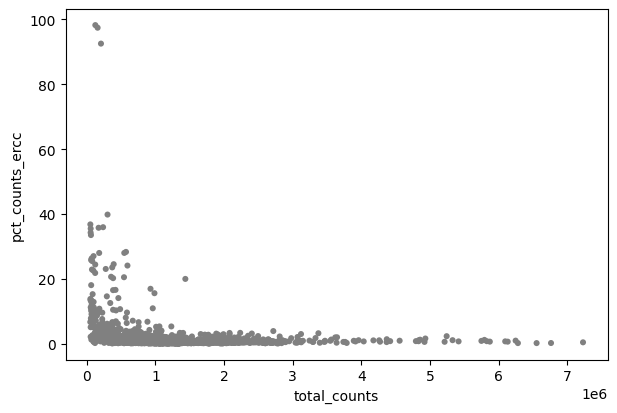

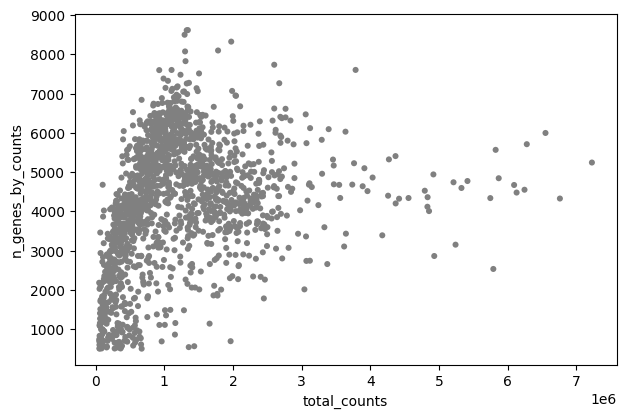

In [13]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_ercc")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [14]:
adata = adata[adata.obs["pct_counts_ercc"] < 20, :]

In [15]:
adata

View of AnnData object with n_obs × n_vars = 1551 × 23433
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_ercc', 'pct_counts_ercc'
    var: 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [16]:
sc.pp.normalize_total(adata, target_sum=CONSTANTS_SS2["norm_count"])
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


/home/research/miniconda3/envs/bioinf/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [17]:
adata.raw = adata

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=float("inf"), min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


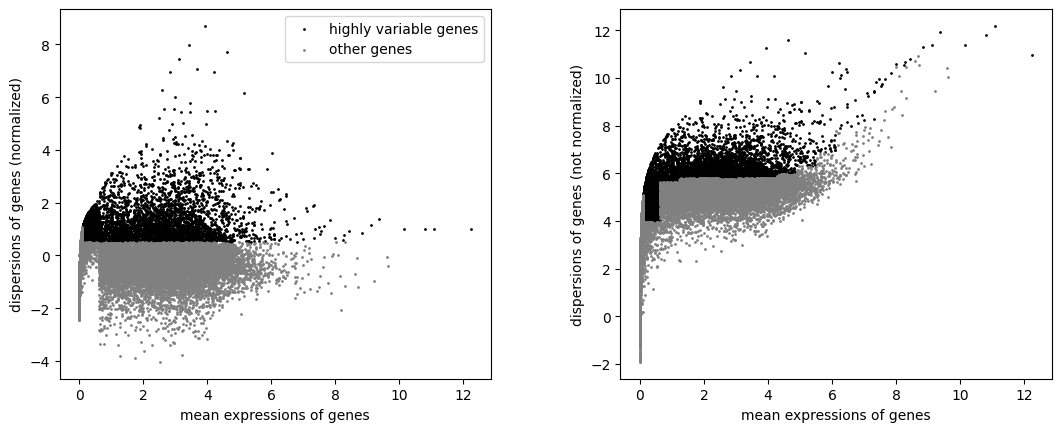

In [19]:
sc.pl.highly_variable_genes(adata)

In [20]:
sum(adata.var["highly_variable"])

5127

In [21]:
# only keep the highly variable genes
adata = adata[:, adata.var.highly_variable]

In [22]:
adata

View of AnnData object with n_obs × n_vars = 1551 × 5127
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_ercc', 'pct_counts_ercc'
    var: 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [23]:
# might not be necessary/beneficial
sc.pp.regress_out(adata, ["total_counts"])

regressing out ['total_counts']
    finished (0:00:05)


In [24]:
# scale?
sc.pp.scale(adata, max_value=10)

### PCA

In [25]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


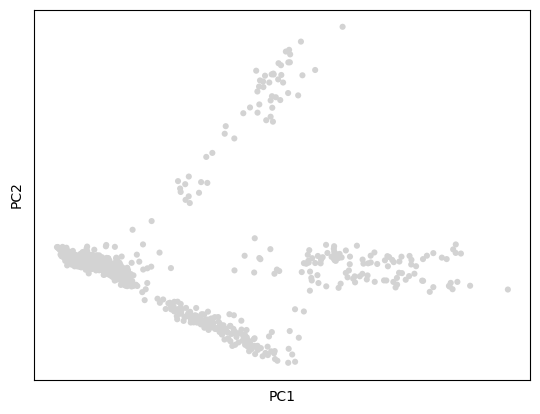

In [26]:
sc.pl.pca(adata)

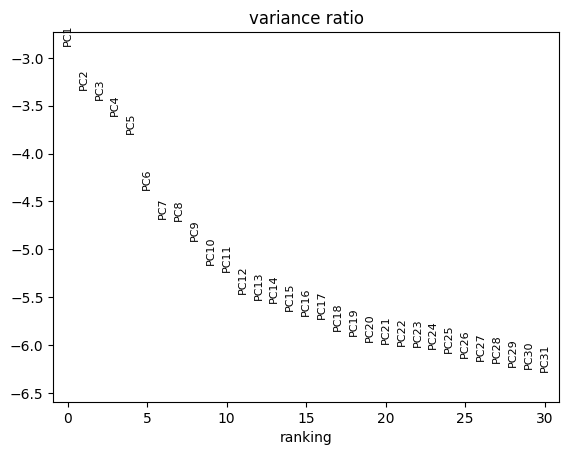

In [27]:
sc.pl.pca_variance_ratio(adata, log=True)

### Neighbors and UMAP

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [29]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


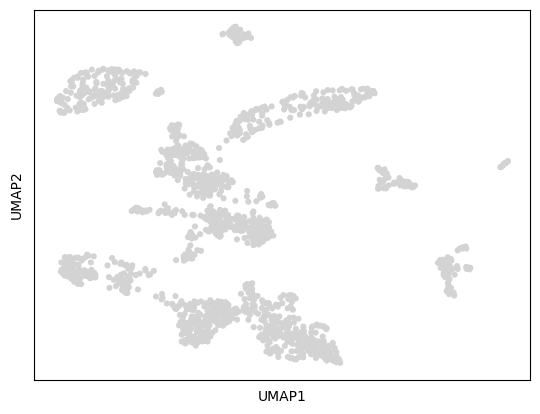

In [30]:
sc.pl.umap(adata)

### Clustering

In [31]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


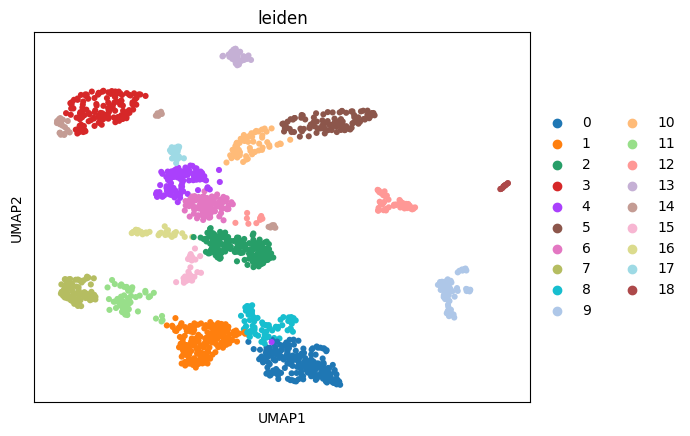

In [32]:
sc.pl.umap(adata, color=["leiden"])

In [33]:
adata.obs

,n_genes,n_counts,n_genes_by_counts,total_counts,total_counts_ercc,pct_counts_ercc,leiden
B21.MAA000574.3_8_M.1.1,2861,4932325.0,2861,4932325.0,84613.0,1.715479,9
B22.MAA000574.3_8_M.1.1,2531,5793032.0,2531,5793032.0,74818.0,1.291517,9
D13.MAA000574.3_8_M.1.1,4168,1986620.0,4168,1986620.0,37596.0,1.892460,12
D14.MAA000574.3_8_M.1.1,1479,1285240.0,1479,1285240.0,29746.0,2.314432,5
C2.MAA000574.3_8_M.1.1,4680,3738020.0,4680,3738020.0,24914.0,0.666503,0
...,...,...,...,...,...,...,...
M16.MAA001868.3_38_F.1.1,2600,170129.0,2600,170129.0,4904.0,2.882519,5
M17.MAA001868.3_38_F.1.1,993,77515.0,993,77515.0,7245.0,9.346579,10
P15.MAA001868.3_38_F.1.1,1450,159228.0,1450,159228.0,2881.0,1.809355,5
I9.MAA001868.3_38_F.1.1,2076,218813.0,2076,218813.0,7440.0,3.400164,5


In [34]:
adata = adata[np.argsort(adata.obs_names), :]

In [35]:
adata.obs

,n_genes,n_counts,n_genes_by_counts,total_counts,total_counts_ercc,pct_counts_ercc,leiden
A1.MAA000884.3_10_M.1.1,4273,644326.0,4273,644326.0,5383.0,0.835447,6
A1.MAA001862.3_39_F.1.1,5920,815428.0,5920,815428.0,3892.0,0.477295,2
A10.MAA000884.3_10_M.1.1,4758,647471.0,4758,647471.0,4326.0,0.668138,0
A10.MAA001857.3_38_F.1.1,4990,1172654.0,4990,1172654.0,9549.0,0.814307,2
A11.MAA000577.3_8_M.1.1,3768,1706353.0,3768,1706353.0,15487.0,0.907608,4
...,...,...,...,...,...,...,...
P8.MAA000910.3_10_M.1.1,1813,395955.0,1813,395955.0,25856.0,6.530035,5
P8.MAA001857.3_38_F.1.1,5943,1548264.0,5943,1548264.0,8818.0,0.569541,2
P9.MAA000574.3_8_M.1.1,619,328109.0,619,328109.0,16701.0,5.090077,10
P9.MAA001857.3_38_F.1.1,2306,361470.0,2306,361470.0,14348.0,3.969347,6


normalizing counts per cell
    finished (0:00:00)


/home/research/miniconda3/envs/bioinf/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


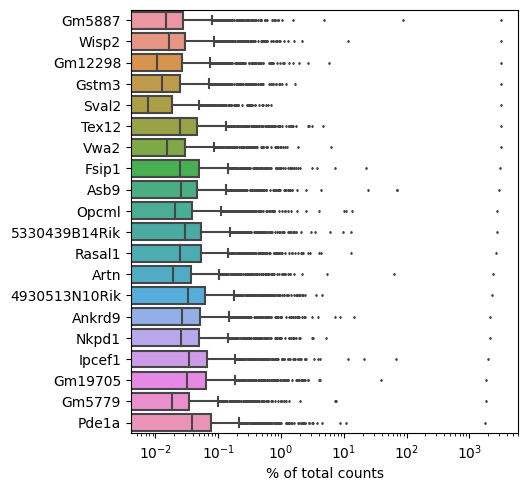

In [37]:
sc.pl.highest_expr_genes(adata, n_top=20, log=True)

AttributeError: 'PathCollection' object has no property 'dpi'

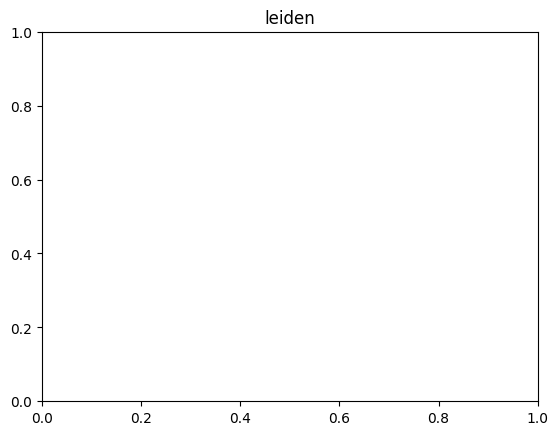

In [52]:
ax = sc.pl.umap(adata, color=["leiden"], show=False)

In [65]:
from io import BytesIO
from PIL import Image

buf = BytesIO()
ax.get_figure().savefig(buf, dpi=600)
buf.seek(0)
img = Image.open(buf)

In [66]:
def convert_rgba_to_rgb(img: Image):
    if img.mode == "RGBA":
        rgb = Image.new("RGB", img.size, (255,255,255)) 
        rgb.paste(img, mask=img.split()[3])
        return rgb
    else:
        return img

In [67]:
img = convert_rgba_to_rgb(img)

In [70]:
img.save("./test.pdf", "PDF", dpi=(600, 600))